In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Defining the data directory
import os
root = "/content/drive/MyDrive/Colab Notebooks/breast cancer classification"
os.chdir(root)

In [3]:
#Importing necessary libraries

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import cv2

In [4]:
#Defining data directory with classification
#You should change paths according to your data location
data = '/content/drive/MyDrive/Colab Notebooks/breast cancer classification/10262'
pos_result = '/content/drive/MyDrive/Colab Notebooks/breast cancer classification/10262/1'
neg_result = '/content/drive/MyDrive/Colab Notebooks/breast cancer classification/10262/0'

In [5]:
#assigning file paths from directories dynamically
dirlist = [pos_result, neg_result]
classes = ['1', '0']
filepaths = []
labels = []
for i, j in zip(dirlist, classes):
    filelist  = os.listdir(i)
    for f in filelist:
        filepath = os.path.join(i,f)
        filepaths.append(filepath)
        labels.append(j)
print('filepaths: ', len(filepaths), 'labels: ', len(labels))

filepaths:  1807 labels:  1807


In [6]:
# creating dataframe containing file paths and classification labels
Files = pd.Series(filepaths, name='filepaths')
Label = pd.Series(labels, name='labels')
df = pd.concat([Files, Label], axis=1)
df = pd.DataFrame(np.array(df).reshape(1807,2), columns = ['filepaths', 'label'])
df.head()

,filepaths,label
0,/content/drive/MyDrive/Colab Notebooks/breast ...,1
1,/content/drive/MyDrive/Colab Notebooks/breast ...,1
2,/content/drive/MyDrive/Colab Notebooks/breast ...,1
3,/content/drive/MyDrive/Colab Notebooks/breast ...,1
4,/content/drive/MyDrive/Colab Notebooks/breast ...,1


In [7]:
# counting values of positive and negative results from dataframe
df['label'].value_counts()

0    1053
1     754
Name: label, dtype: int64

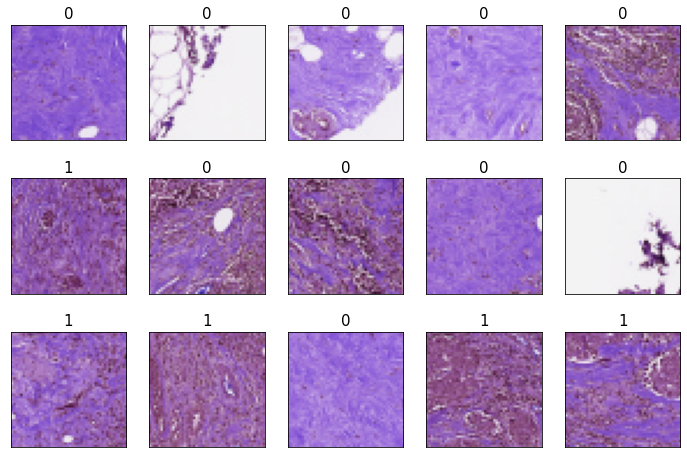

In [8]:
#visualization breast tumar random images from dataset

plt.figure(figsize = (12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "label"], size = 15, color = 'black')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [9]:
# importing method to split train, test, and validation data
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, train_size = 0.93, random_state = 0)
train, valid = train_test_split(train_val, train_size = 0.90, random_state=0)

print(f"train set shape: {train.shape}")
print(f"test ste shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (1512, 2)
test ste shape: (127, 2)
validation set shape: (168, 2)


In [10]:
# scaling training image and genarating data from train, test and validation images
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

In [11]:
# creating augmented data from dataframe by preprocessing tool flow_from_dataframe
train_gen = train_datagen.flow_from_dataframe(train,
                                              x_col = 'filepaths',
                                              y_col = 'label',
                                              target_size = (224,224),
                                              batch_size = 32,
                                              class_mode = 'binary',
                                              shuffle = True)
valid_gen = valid_datagen.flow_from_dataframe(valid,
                                              x_col = 'filepaths',
                                              y_col = 'label',
                                              target_size = (224,224),
                                              batch_size = 16,
                                              class_mode = 'binary',
                                              shuffle = True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            x_col = 'filepaths',
                                            y_col = 'label',
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'binary',
                                            shuffle = False)



Found 1512 validated image filenames belonging to 2 classes.
Found 168 validated image filenames belonging to 2 classes.
Found 127 validated image filenames belonging to 2 classes.


In [12]:
# checking class data index
train_gen.class_indices

{'0': 0, '1': 1}

In [13]:
from tensorflow import keras

base_model = keras.applications.resnet_v2.ResNet50V2(
    weights = "imagenet",   #load weights pre-trained in ImageNet
    input_shape = (224, 224, 3),
    include_top = False
)

#freeze the base model
base_model.trainable = False

#Create new model on top
inputs  = keras.Input(shape=(224, 224, 3))

# assigning data size to base model and itarate with new model
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)    #regilarize with dropouts
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [14]:
# apply training model on data
callbacks = [
             tf.keras.callbacks.ModelCheckpoint("Breast_tumour_classifire_model.h5", save_best_only = True, verbose = 0)
]

model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['accuracy'])

history = model.fit(train_gen,
                    validation_data = valid_gen,
                    epochs = 20,
                    callbacks = [callbacks],
                    verbose = 1)



Epoch 1/20
48/48 [==============================] - 437s 9s/step - loss: 0.7198 - accuracy: 0.5503 - val_loss: 0.7481 - val_accuracy: 0.5060
Epoch 2/20
48/48 [==============================] - 248s 5s/step - loss: 0.6260 - accuracy: 0.6310 - val_loss: 0.6671 - val_accuracy: 0.5774
Epoch 3/20
48/48 [==============================] - 246s 5s/step - loss: 0.5359 - accuracy: 0.7222 - val_loss: 0.6160 - val_accuracy: 0.6310
Epoch 4/20
48/48 [==============================] - 248s 5s/step - loss: 0.4822 - accuracy: 0.7798 - val_loss: 0.5817 - val_accuracy: 0.6607
Epoch 5/20
48/48 [==============================] - 253s 5s/step - loss: 0.4522 - accuracy: 0.8089 - val_loss: 0.5528 - val_accuracy: 0.7143
Epoch 6/20
48/48 [==============================] - 246s 5s/step - loss: 0.4298 - accuracy: 0.8122 - val_loss: 0.5251 - val_accuracy: 0.7560
Epoch 7/20
48/48 [==============================] - 244s 5s/step - loss: 0.4218 - accuracy: 0.8287 - val_loss: 0.5031 - val_accuracy: 0.7738
Epoch 8/20
48

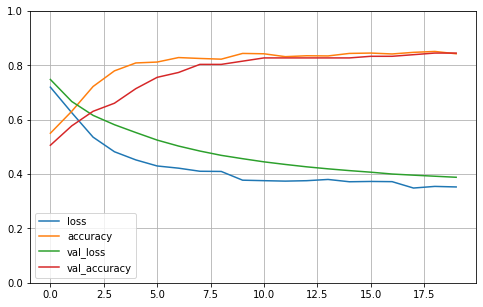

In [15]:
# plotting comparison of trainong loss and validations loss
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [20]:
# predicting from base model

from PIL import Image

#Here you should provide the model link what you saved before
model_path = "/content/drive/MyDrive/Colab Notebooks/breast cancer classification/Breast_tumour_classifire_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/breast cancer classification/8864/1/8864_idx5_x1601_y2451_class1.png")

image_from_array = Image.fromarray(image, 'RGB')
resize_image = image_from_array.resize((224,224))
expand_input = np.expand_dims(resize_image, axis=0)
input_data = np.array(expand_input)
input_data = input_data/255


pred = loaded_model.predict(input_data)

if pred >= 0.5:
    print("The tumor is melignent")
else:
    print("The tumar is not melignent")



The tumor is melignent
